# imports and setup

In [1]:
!pip install --upgrade xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [1]:
pip install ordinalgbt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.5 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import numpy as np

import matplotlib.pyplot as plt

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.metrics import mean_squared_error

from sklearn.utils.class_weight import compute_class_weight


import xgboost as xgb

from ordinalgbt.lgb import LGBMOrdinal


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# load data


In [4]:
# data_orig = pd.read_csv("/content/drive/MyDrive/Spring 2025/ML and Climate/wildfire_project/ca_2000_mean_fire_earth_data.csv")
# data_orig = pd.read_csv("/content/drive/MyDrive/Spring 2025/ML and Climate/wildfire_project/ca_2000_day_of_year_mean_fire_earth_data.csv")
data_orig = pd.read_csv("/content/drive/MyDrive/Spring 2025/ML and Climate/wildfire_project/long_2000_mean_fire_earth_data.csv")


In [5]:
print(data_orig.columns.tolist())


# drop unused variables
# drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE_CLASS', 'FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'date', 'dead_fuel_100']
# drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE', 'FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'date', 'dead_fuel_100']
drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE',  'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE',  'date', 'dead_fuel_100']

data_class = data_orig.drop(columns=drop_cols)

# make the prediction numeric instead of alphabetic
data_class['FIRE_SIZE_CLASS'].unique()
mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
data_class['FIRE_SIZE_CLASS_NUM'] = data_class['FIRE_SIZE_CLASS'].map(mapping)
data_class = data_class.drop(columns=['FIRE_SIZE_CLASS'])


# data_class['temp_C'] = (data_class['min_temp_C'] + data_class['max_temp_C'])/2
# data_class = data_class.drop(columns=['min_temp_C', 'max_temp_C'])

# drop invalid rows
df = data_class.dropna()

data_class


['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'FIRE_YEAR', 'DISCOVERY_DATE', 'CONT_DATE', 'DURATION_DAYS', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'DISCOVERY_DOY', 'date', 'dead_fuel_100', 'dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C', 'min_temp_C', 'precipitation', 'wind_speed', 'population_density', 'vegetation', 'drought_index']


,FIRE_YEAR,CONT_DATE,DURATION_DAYS,LATITUDE,LONGITUDE,DISCOVERY_DOY,dead_fuel_1000,energy_release,humidity,max_temp_C,min_temp_C,precipitation,wind_speed,population_density,vegetation,drought_index,FIRE_SIZE_CLASS_NUM
0,2004,2453189.5,5.0,38.559167,-119.913333,180,8.259057,76.284248,0.004474,20.343042,7.937524,0.0,2.230986,0.000000,2384.0,-2.6175,1
1,2004,2453189.5,5.0,38.559167,-119.933056,180,8.259057,76.284248,0.004474,20.343042,7.937524,0.0,2.230986,0.000000,2384.0,-2.6175,1
2,2004,2453299.5,15.0,38.523333,-120.211667,280,7.771585,77.266144,0.004487,23.897638,9.720789,0.0,2.096183,0.000000,2080.0,-3.6375,7
3,2004,2453295.5,4.0,38.780000,-120.260000,287,7.529254,78.958511,0.003525,23.471399,9.278833,0.0,3.542572,0.546957,1560.0,-3.3975,7
4,2004,2453192.5,5.0,33.545278,-105.229444,183,9.743317,64.935120,0.003591,28.284021,11.238000,0.0,3.919152,0.325217,1913.0,0.4950,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61195,2010,2455404.5,2.0,41.273543,-120.580424,206,7.325874,81.276794,0.006939,31.968591,15.125696,0.0,2.236683,0.372284,1549.0,-3.9650,1
61196,2014,2456816.5,2.0,37.600389,-120.191168,157,7.395751,83.421936,0.005318,33.718073,16.510370,0.0,3.303576,0.498421,1872.0,-4.7675,5
61197,2014,2456845.5,4.0,36.032229,-118.857999,184,4.720404,96.394150,0.007447,38.930841,21.166345,0.0,3.026281,8.687964,1662.0,-5.6475,1
61198,2015,2457237.5,5.0,40.469090,-122.397660,210,6.130595,92.727119,0.004246,42.192865,22.842554,0.0,2.567572,40.920891,2493.0,-3.8075,3


In [6]:
print(data_class.columns.tolist())


['FIRE_YEAR', 'CONT_DATE', 'DURATION_DAYS', 'LATITUDE', 'LONGITUDE', 'DISCOVERY_DOY', 'dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C', 'min_temp_C', 'precipitation', 'wind_speed', 'population_density', 'vegetation', 'drought_index', 'FIRE_SIZE_CLASS_NUM']


In [16]:

df['DOY_sin'] = np.sin(2 * np.pi * df['DISCOVERY_DOY']/365)
df['DOY_cos'] = np.cos(2 * np.pi * df['DISCOVERY_DOY']/365)

# X = df[['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
#         'min_temp_C', 'precipitation', 'wind_speed',
#         'population_density', 'vegetation', 'drought_index', 'DISCOVERY_DOY']].values

X = df[['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
        'precipitation', 'wind_speed',
        'population_density', 'vegetation', 'drought_index',  'DOY_sin', 'DOY_cos',
        'LATITUDE', 'LONGITUDE']].values
y = df['FIRE_SIZE_CLASS_NUM'].values - 1  # classes start at 1, shift to 0 for pytorch

# Scale the inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)


smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train.numpy(), y_train.numpy())

# Convert back to tensors
X_train = torch.tensor(X_resampled, dtype=torch.float32)
y_train = torch.tensor(y_resampled, dtype=torch.long)


<ipython-input-16-0166a557ea67>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOY_sin'] = np.sin(2 * np.pi * df['DISCOVERY_DOY']/365)
<ipython-input-16-0166a557ea67>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOY_cos'] = np.cos(2 * np.pi * df['DISCOVERY_DOY']/365)


# test different types of models

## neural network

In [8]:


class FireSizeClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FireSizeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout(F.relu(self.bn3(self.fc3(x))))
        x = self.fc4(x)
        return x


# Setup
input_dim = X_train.shape[1]
num_classes = len(set(y))
model = FireSizeClassifier(input_dim, num_classes)

class_counts = np.bincount(y_train.numpy())
for cls, count in enumerate(class_counts, start=1):
    print(f"Class {cls}: {count} samples")

# Weight loss for class imbalance
total_samples = len(y_train)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)

val_losses = []
train_losses = []

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_preds = val_outputs.argmax(dim=1)
        val_accuracy = (val_preds == y_val).float().mean()

    val_losses.append(val_loss)
    train_losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_accuracy:.4f}")


Class 1: 17571 samples
Class 2: 17571 samples
Class 3: 17571 samples
Class 4: 17571 samples
Class 5: 17571 samples
Class 6: 17571 samples
Class 7: 17571 samples
Epoch 10, Train Loss: 1.9060, Val Loss: 1.9312, Val Acc: 0.1319
Epoch 20, Train Loss: 1.8559, Val Loss: 1.8367, Val Acc: 0.2576
Epoch 30, Train Loss: 1.8279, Val Loss: 1.7711, Val Acc: 0.2894
Epoch 40, Train Loss: 1.8089, Val Loss: 1.7543, Val Acc: 0.3043
Epoch 50, Train Loss: 1.7965, Val Loss: 1.7313, Val Acc: 0.3158
Epoch 60, Train Loss: 1.7867, Val Loss: 1.7087, Val Acc: 0.3267
Epoch 70, Train Loss: 1.7781, Val Loss: 1.6904, Val Acc: 0.3358
Epoch 80, Train Loss: 1.7717, Val Loss: 1.6794, Val Acc: 0.3390
Epoch 90, Train Loss: 1.7653, Val Loss: 1.6698, Val Acc: 0.3415
Epoch 100, Train Loss: 1.7600, Val Loss: 1.6629, Val Acc: 0.3428


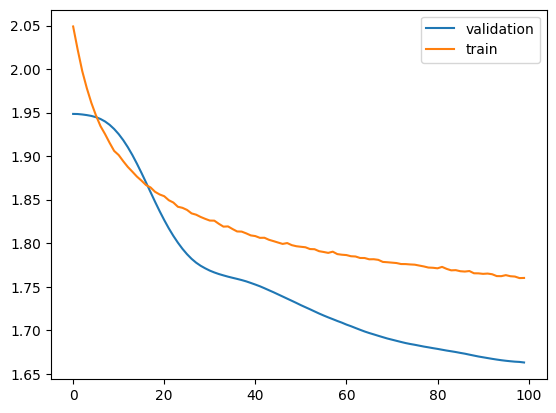

In [9]:
plt.plot(val_losses, label='validation')
plt.plot(train_losses, label='train')
plt.legend()
plt.show()

In [10]:
new_sample = df.sample(n=1)
print(new_sample)
X = new_sample[['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
        'precipitation', 'wind_speed',
        'population_density', 'vegetation', 'drought_index',  'DOY_sin', 'DOY_cos',
        'LATITUDE', 'LONGITUDE']].values
y = new_sample['FIRE_SIZE_CLASS_NUM'].values - 1  # classes start at 1, shift to 0 for pytorch


# Preprocess
new_sample_scaled = scaler.transform(X)
new_sample_tensor = torch.tensor(new_sample_scaled, dtype=torch.float32)

# Predict
model.eval()
with torch.no_grad():
    output = model(new_sample_tensor)
    print(output)
    predicted_class = output.argmax(dim=1).item()
    predicted_class += 1

print(f"Predicted FIRE_SIZE_CLASS_NUM: {predicted_class}")


      FIRE_YEAR  CONT_DATE  DURATION_DAYS   LATITUDE  LONGITUDE  \
4508       2007  2454339.5            9.0  37.551389   -112.695   

      DISCOVERY_DOY  dead_fuel_1000  energy_release  humidity  max_temp_C  \
4508            230       15.018412       39.810574  0.008729   21.368372   

      min_temp_C  precipitation  wind_speed  population_density  vegetation  \
4508    8.233514       0.148538    4.718508            0.172652      2435.0   

      drought_index  FIRE_SIZE_CLASS_NUM   DOY_sin   DOY_cos  
4508        -4.1125                    2 -0.729558 -0.683919  
tensor([[ 1.0584,  0.7631,  0.1671, -0.1559, -0.2117, -0.3598, -1.0757]])
Predicted FIRE_SIZE_CLASS_NUM: 1


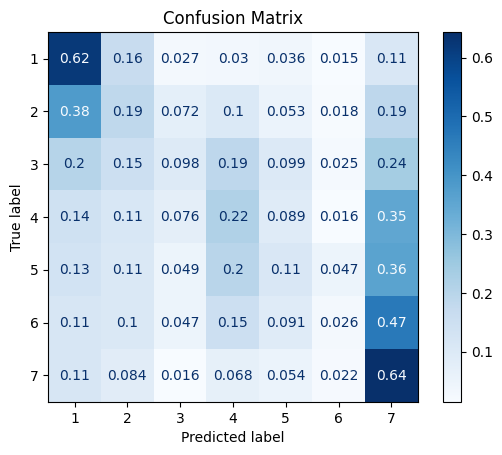

Validation accuracy: 0.3428
              precision    recall  f1-score   support

     Class 1       0.62      0.58      0.60      4667
     Class 2       0.19      0.36      0.25      1834
     Class 3       0.10      0.23      0.14       635
     Class 4       0.22      0.13      0.16      1141
     Class 5       0.11      0.09      0.10       688
     Class 6       0.03      0.07      0.04       228
     Class 7       0.64      0.10      0.17      2456

    accuracy                           0.34     11649
   macro avg       0.27      0.22      0.21     11649
weighted avg       0.45      0.34      0.34     11649



In [17]:

# Predict
model.eval()
with torch.no_grad():
    val_outputs = model(X_val)
    val_preds = val_outputs.argmax(dim=1)

# Shift classes back if necessary
val_preds_shifted = val_preds + 1
y_val_shifted = y_val + 1

# Confusion matrix
cm = confusion_matrix(y_val_shifted.cpu(), val_preds_shifted.cpu(), normalize='true')


# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6,7])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# report
acc = (val_preds_shifted == y_val_shifted).float().mean()
print(f"Validation accuracy: {acc:.4f}")
print(classification_report(val_preds_shifted, y_val_shifted, target_names=[f"Class {i}" for i in range(1, len(class_counts)+1)]))




## svm

In [18]:

# Features and target

X = df[['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
'precipitation', 'wind_speed',
'population_density', 'vegetation', 'drought_index',  'DOY_sin', 'DOY_cos',
'LATITUDE', 'LONGITUDE']]

y = df['FIRE_SIZE_CLASS_NUM']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,  stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [19]:

# Automatically balance classes
svm = SVC(class_weight='balanced', probability=True)

# Train
svm.fit(X_train, y_train)


SVC(class_weight='balanced', probability=True)

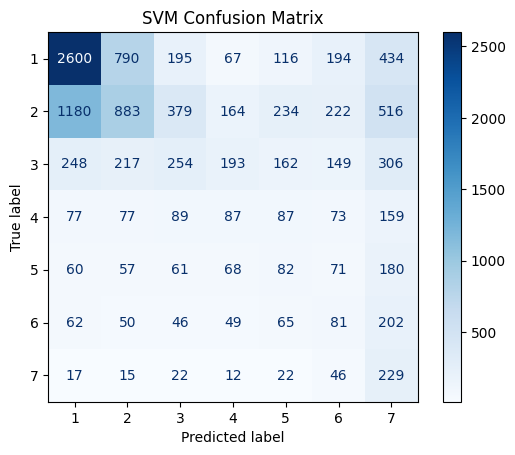

Validation accuracy: 0.3619
              precision    recall  f1-score   support

     Class 1       0.61      0.59      0.60      4396
     Class 2       0.42      0.25      0.31      3578
     Class 3       0.24      0.17      0.20      1529
     Class 4       0.14      0.13      0.13       649
     Class 5       0.11      0.14      0.12       579
     Class 6       0.10      0.15      0.12       555
     Class 7       0.11      0.63      0.19       363

    accuracy                           0.36     11649
   macro avg       0.25      0.29      0.24     11649
weighted avg       0.41      0.36      0.37     11649

Validation Accuracy: 0.3619


In [20]:

# Predict
y_pred = svm.predict(X_val)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
disp.plot(cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.show()

acc = (y_pred == y_val).mean()
print(f"Validation accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred, target_names=[f"Class {i}" for i in range(1, len(class_counts)+1)]))


# Accuracy
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")


## xgboost


In [21]:


features = ['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
            'precipitation', 'wind_speed', 'population_density', 'vegetation',
            'drought_index', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE']

df['DOY_sin'] = np.sin(2 * np.pi * df['DISCOVERY_DOY']/365)
df['DOY_cos'] = np.cos(2 * np.pi * df['DISCOVERY_DOY']/365)

# Combine features
features += [ 'DOY_sin', 'DOY_cos']

# Inputs and target
X = df[features].values
y = df['FIRE_SIZE_CLASS_NUM'].values - 1  # Shift class labels to 0-based

# Scale inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,  stratify=y)


<ipython-input-21-dfed7d1c44f8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOY_sin'] = np.sin(2 * np.pi * df['DISCOVERY_DOY']/365)
<ipython-input-21-dfed7d1c44f8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOY_cos'] = np.cos(2 * np.pi * df['DISCOVERY_DOY']/365)


[17579 14311  6116  2597  2315  2221  1453]


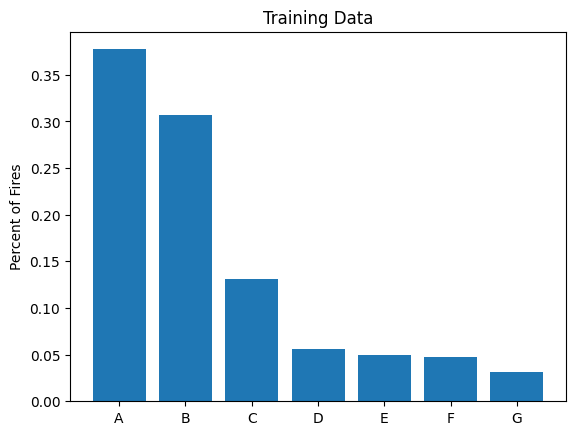

[4396 3578 1529  649  579  555  363]


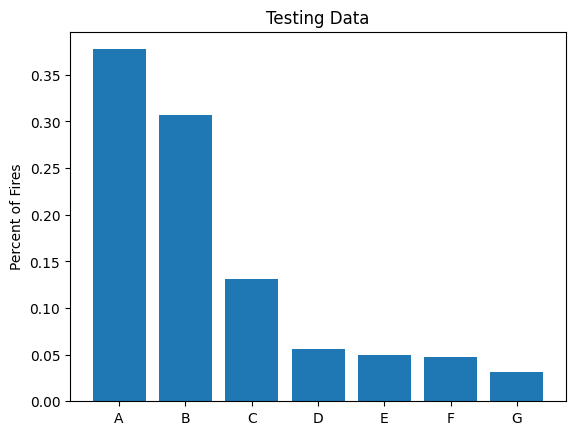

In [22]:
# Class frequencies
class_counts = np.bincount(y_train)
total_samples = len(y_train)
print(class_counts)
class_counts = class_counts / total_samples

plt.bar(['A','B','C','D','E','F','G'], class_counts)
plt.ylabel("Percent of Fires")
plt.title("Training Data")
plt.show()

class_counts = np.bincount(y_val)
total_samples = len(y_val)
print(class_counts)
class_counts = class_counts / total_samples

plt.bar(['A','B','C','D','E','F','G'], class_counts)
plt.title("Testing Data")

plt.ylabel("Percent of Fires")

plt.show()
# Inverse frequency
class_weights = total_samples / (len(class_counts) * class_counts)

# Map weight for each sample
sample_weights = np.array([class_weights[label] for label in y_train])


In [23]:

# Create classifier
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_counts),
    eval_metric='mlogloss',
    learning_rate=0.1,
    # n_estimators=200,
    # max_depth=6,
    max_depth=8,
    n_estimators=500  ,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
)


# Fit with sample weights
model.fit(X_train, y_train, sample_weight=sample_weights, eval_set=[(X_val, y_val)], verbose=10)


[0]	validation_0-mlogloss:1.90844


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:57:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-mlogloss:1.69227
[20]	validation_0-mlogloss:1.60280
[30]	validation_0-mlogloss:1.55834
[40]	validation_0-mlogloss:1.53038
[50]	validation_0-mlogloss:1.51163
[60]	validation_0-mlogloss:1.49756
[70]	validation_0-mlogloss:1.48734
[80]	validation_0-mlogloss:1.47852
[90]	validation_0-mlogloss:1.47099
[100]	validation_0-mlogloss:1.46414
[110]	validation_0-mlogloss:1.45828
[120]	validation_0-mlogloss:1.45260
[130]	validation_0-mlogloss:1.44792
[140]	validation_0-mlogloss:1.44328
[150]	validation_0-mlogloss:1.43759
[160]	validation_0-mlogloss:1.43361
[170]	validation_0-mlogloss:1.43018
[180]	validation_0-mlogloss:1.42625
[190]	validation_0-mlogloss:1.42351
[200]	validation_0-mlogloss:1.42022
[210]	validation_0-mlogloss:1.41772
[220]	validation_0-mlogloss:1.41551
[230]	validation_0-mlogloss:1.41438
[240]	validation_0-mlogloss:1.41201
[250]	validation_0-mlogloss:1.41045
[260]	validation_0-mlogloss:1.40951
[270]	validation_0-mlogloss:1.40835
[280]	validation_0-mlogloss:1.40724
[

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=7, num_parallel_tree=None, ...)

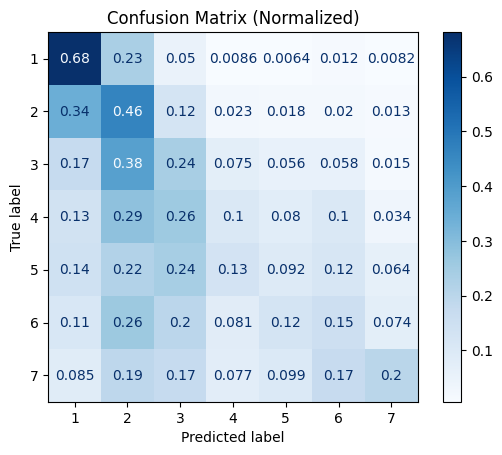

Validation accuracy: 0.4534
              precision    recall  f1-score   support

     Class 1       0.63      0.68      0.65      4396
     Class 2       0.43      0.46      0.45      3578
     Class 3       0.24      0.24      0.24      1529
     Class 4       0.15      0.10      0.12       649
     Class 5       0.14      0.09      0.11       579
     Class 6       0.17      0.15      0.16       555
     Class 7       0.26      0.20      0.23       363

    accuracy                           0.45     11649
   macro avg       0.29      0.28      0.28     11649
weighted avg       0.43      0.45      0.44     11649



In [24]:
# Predict on validation
y_pred = model.predict(X_val)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, len(class_counts)+1))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Normalized)")
plt.show()

# Accuracy and classification report
acc = (y_pred == y_val).mean()
print(f"Validation accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred, target_names=[f"Class {i}" for i in range(1, len(class_counts)+1)]))



## ordinal light grad boosting

In [25]:
# classes = np.array([0,1,2,3,4,5,6])
# # print(set(y_train))
# y_train_np = np.array([y.item() if isinstance(y, torch.Tensor) else y for y in y_train])

# weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_np)
# class_weight_dict = dict(zip(classes, weights))

# model = LGBMOrdinal(
#     class_weight=class_weight_dict
# )
model = LGBMOrdinal(class_weight='balanced')
# model = LGBMOrdinal()
model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LGBMOrdinal(class_weight='balanced',
            objective=<function LGBMOrdinal._lgb_loss_factory.<locals>.loss at 0x7cc00cf61a80>)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


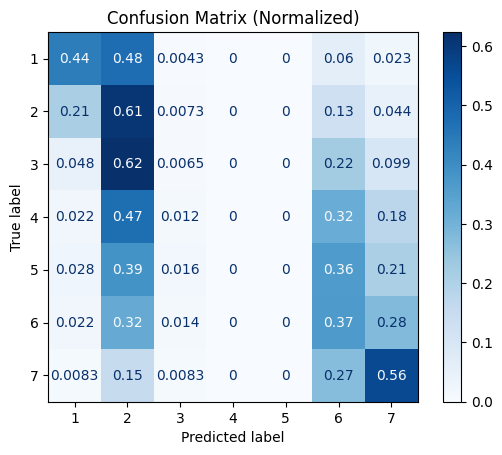

Validation accuracy: 0.3872
              precision    recall  f1-score   support

     Class 1       0.69      0.44      0.53      4396
     Class 2       0.36      0.61      0.45      3578
     Class 3       0.12      0.01      0.01      1529
     Class 4       0.00      0.00      0.00       649
     Class 5       0.00      0.00      0.00       579
     Class 6       0.11      0.37      0.17       555
     Class 7       0.20      0.56      0.30       363

    accuracy                           0.39     11649
   macro avg       0.21      0.28      0.21     11649
weighted avg       0.40      0.39      0.36     11649



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
# Predict on validation
y_pred = model.predict(X_val)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, len(class_counts)+1))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Normalized)")
plt.show()

# print(y_pred)
# Accuracy and classification report
acc = (y_pred == y_val).mean()
print(f"Validation accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred, target_names=[f"Class {i}" for i in range(1, len(class_counts)+1)]))



# testing for fires that lasted longer than 1 week


In [ ]:

df_long = df[df["DURATION_DAYS"]>=7]
df_long


In [ ]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(df_long['FIRE_SIZE_CLASS_NUM'], bins=range(int(df_long['FIRE_SIZE_CLASS_NUM'].min()), int(df_long['FIRE_SIZE_CLASS_NUM'].max()) + 2), align='left', rwidth=0.8)
plt.xlabel('FIRE_SIZE_CLASS_NUM')
plt.ylabel('Frequency')
plt.title('Histogram of FIRE_SIZE_CLASS_NUM')
plt.xticks(sorted(df_long['FIRE_SIZE_CLASS_NUM'].unique()))
plt.grid(axis='y')

plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Original features
features = ['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
            'precipitation', 'wind_speed', 'population_density', 'vegetation',
            'drought_index', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE',]

# Optional engineered features
df_long['DOY_sin'] = np.sin(2 * np.pi * df_long['DISCOVERY_DOY']/365)
df_long['DOY_cos'] = np.cos(2 * np.pi * df_long['DISCOVERY_DOY']/365)

# Combine features
features += [ 'DOY_sin', 'DOY_cos']


features = ['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
            'precipitation', 'wind_speed', 'population_density', 'vegetation',
            'drought_index', 'DISCOVERY_DOY', 'LATITUDE',
            'LONGITUDE',  'DOY_sin', 'DOY_cos']



# Inputs and target
X = df_long[features].values
y = df_long['FIRE_SIZE_CLASS_NUM'].values - 1  # Shift class labels to 0-based

# Scale inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Class frequencies
class_counts = np.bincount(y_train)
total_samples = len(y_train)

# Inverse frequency
class_weights = total_samples / (len(class_counts) * class_counts)

# Map weight for each sample
sample_weights = np.array([class_weights[label] for label in y_train])

In [ ]:
import xgboost as xgb

# Create classifier
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_counts),
    eval_metric='mlogloss',
    learning_rate=0.1,
    # n_estimators=200,
    # max_depth=6,
    max_depth=8,
    n_estimators=500  ,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    random_state=42
)



# Fit with sample weights
model.fit(X_train, y_train, sample_weight=sample_weights, eval_set=[(X_val, y_val)], verbose=10)


In [ ]:
# Predict on validation
y_pred = model.predict(X_val)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, len(class_counts)+1))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Normalized)")
plt.show()

# Accuracy and classification report
acc = (y_pred == y_val).mean()
print(f"Validation accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred, target_names=[f"Class {i}" for i in range(1, len(class_counts)+1)]))


In [ ]:
print(*features)

# compare correlational models with only

In [29]:
df['temp_C'] = (df['min_temp_C'] + df['max_temp_C'])/2


features = [ 'humidity', 'temp_C',
            'precipitation', 'wind_speed', 'population_density', 'vegetation',
            'drought_index']


# Inputs and target
X = df[features].values
y = df['FIRE_SIZE_CLASS_NUM'].values - 1  # Shift class labels to 0-based

# Scale inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,  stratify=y)


<ipython-input-29-d9e157f5caf6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_C'] = (df['min_temp_C'] + df['max_temp_C'])/2


In [30]:
# Class frequencies
class_counts = np.bincount(y_train)
total_samples = len(y_train)

# Inverse frequency
class_weights = total_samples / (len(class_counts) * class_counts)

# Map weight for each sample
sample_weights = np.array([class_weights[label] for label in y_train])


### xgboost

In [31]:

# Create classifier
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_counts),
    eval_metric='mlogloss',
    learning_rate=0.1,
    # n_estimators=200,
    # max_depth=6,
    max_depth=8,
    n_estimators=500  ,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
)



# Fit with sample weights
model.fit(X_train, y_train, sample_weight=sample_weights, eval_set=[(X_val, y_val)], verbose=10)


[0]	validation_0-mlogloss:1.92217


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:59:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-mlogloss:1.78628
[20]	validation_0-mlogloss:1.72453
[30]	validation_0-mlogloss:1.69356
[40]	validation_0-mlogloss:1.67403
[50]	validation_0-mlogloss:1.66293
[60]	validation_0-mlogloss:1.65462
[70]	validation_0-mlogloss:1.64808
[80]	validation_0-mlogloss:1.64199
[90]	validation_0-mlogloss:1.63724
[100]	validation_0-mlogloss:1.63151
[110]	validation_0-mlogloss:1.62553
[120]	validation_0-mlogloss:1.62071
[130]	validation_0-mlogloss:1.61707
[140]	validation_0-mlogloss:1.61256
[150]	validation_0-mlogloss:1.60802
[160]	validation_0-mlogloss:1.60372
[170]	validation_0-mlogloss:1.60047
[180]	validation_0-mlogloss:1.59758
[190]	validation_0-mlogloss:1.59383
[200]	validation_0-mlogloss:1.59041
[210]	validation_0-mlogloss:1.58683
[220]	validation_0-mlogloss:1.58406
[230]	validation_0-mlogloss:1.58091
[240]	validation_0-mlogloss:1.57838
[250]	validation_0-mlogloss:1.57559
[260]	validation_0-mlogloss:1.57256
[270]	validation_0-mlogloss:1.56963
[280]	validation_0-mlogloss:1.56769
[

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=7, num_parallel_tree=None, ...)

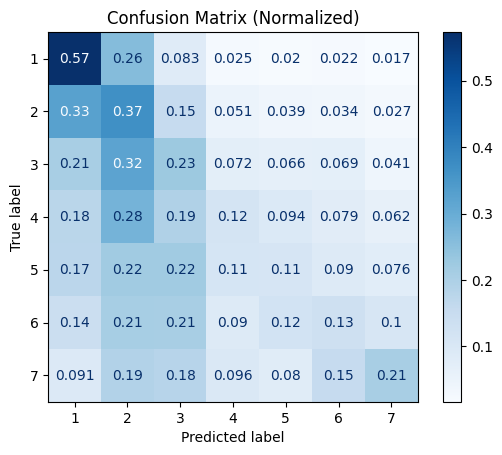

Validation accuracy: 0.3831
              precision    recall  f1-score   support

     Class 1       0.58      0.57      0.58      4396
     Class 2       0.38      0.37      0.37      3578
     Class 3       0.20      0.23      0.21      1529
     Class 4       0.12      0.12      0.12       649
     Class 5       0.11      0.11      0.11       579
     Class 6       0.13      0.13      0.13       555
     Class 7       0.17      0.21      0.18       363

    accuracy                           0.38     11649
   macro avg       0.24      0.25      0.24     11649
weighted avg       0.39      0.38      0.39     11649



In [32]:
# Predict on validation
y_pred = model.predict(X_val)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, len(class_counts)+1))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Normalized)")
plt.show()

# Accuracy and classification report
acc = (y_pred == y_val).mean()
print(f"Validation accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred, target_names=[f"Class {i}" for i in range(1, len(class_counts)+1)]))



### ordingal lgbm

In [33]:
model = LGBMOrdinal(class_weight='balanced')
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LGBMOrdinal(class_weight='balanced',
            objective=<function LGBMOrdinal._lgb_loss_factory.<locals>.loss at 0x7cc00b26b560>)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


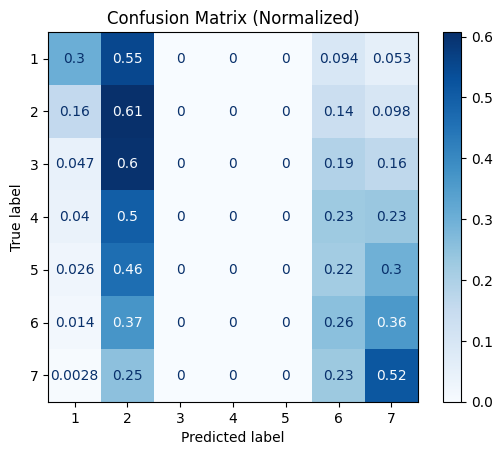

Validation accuracy: 0.3288
              precision    recall  f1-score   support

     Class 1       0.66      0.30      0.41      4396
     Class 2       0.34      0.61      0.44      3578
     Class 3       0.00      0.00      0.00      1529
     Class 4       0.00      0.00      0.00       649
     Class 5       0.00      0.00      0.00       579
     Class 6       0.08      0.26      0.13       555
     Class 7       0.12      0.52      0.20       363

    accuracy                           0.33     11649
   macro avg       0.17      0.24      0.17     11649
weighted avg       0.36      0.33      0.30     11649

Mean Squared Error (MSE): 5.0872


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
# Predict on validation
y_pred = model.predict(X_val)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, len(class_counts)+1))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Normalized)")
plt.show()

# Accuracy and classification report
acc = (y_pred == y_val).mean()
print(f"Validation accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred, target_names=[f"Class {i}" for i in range(1, len(class_counts)+1)]))

# Mean Squared Error
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# generalization (train prior 2014)


In [37]:


features = ['dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C',
            'precipitation', 'wind_speed', 'population_density', 'vegetation',
            'drought_index', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE']

df['DOY_sin'] = np.sin(2 * np.pi * df['DISCOVERY_DOY']/365)
df['DOY_cos'] = np.cos(2 * np.pi * df['DISCOVERY_DOY']/365)

# Combine features
features += [ 'DOY_sin', 'DOY_cos']

scaler = StandardScaler()
X = scaler.fit_transform(X)


# Inputs and target
X_val = df[df['FIRE_YEAR'] >= 2014][features].values
X_train = df[df['FIRE_YEAR'] < 2014][features].values
y_val = df[df['FIRE_YEAR'] >= 2014]['FIRE_SIZE_CLASS_NUM'].values - 1  # Shift class labels to 0-based
y_train = df[df['FIRE_YEAR'] < 2014]['FIRE_SIZE_CLASS_NUM'].values - 1  # Shift class labels to 0-based



<ipython-input-37-3e9181592721>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOY_sin'] = np.sin(2 * np.pi * df['DISCOVERY_DOY']/365)
<ipython-input-37-3e9181592721>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOY_cos'] = np.cos(2 * np.pi * df['DISCOVERY_DOY']/365)


[16778 14211  6550  2844  2559  2521  1630]


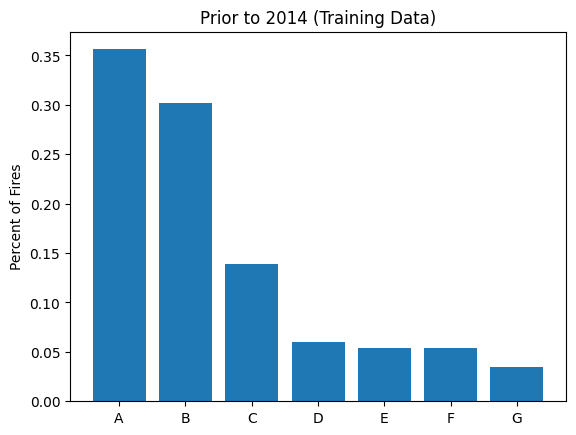

[5197 3678 1095  402  335  255  186]


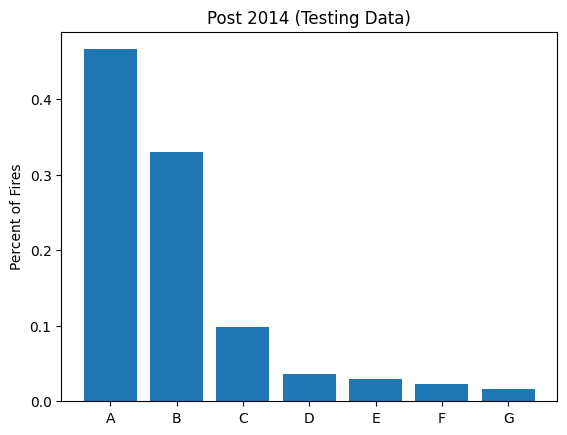

In [38]:
# Class frequencies
class_counts = np.bincount(y_train)
total_samples = len(y_train)
print(class_counts)
class_counts = class_counts / total_samples
plt.bar(['A','B','C','D','E','F','G'], class_counts)
plt.title("Prior to 2014 (Training Data)")
plt.ylabel("Percent of Fires")
plt.show()
class_counts = np.bincount(y_val)
total_samples = len(y_val)
print(class_counts)
class_counts = class_counts / total_samples

plt.bar(['A','B','C','D','E','F','G'], class_counts)
plt.title("Post 2014 (Testing Data)")
plt.ylabel("Percent of Fires")

plt.show()
# Inverse frequency
class_weights = total_samples / (len(class_counts) * class_counts)

# Map weight for each sample
sample_weights = np.array([class_weights[label] for label in y_train])


### xgboost

In [39]:

# Create classifier
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_counts),
    eval_metric='mlogloss',
    learning_rate=0.1,
    # n_estimators=200,
    # max_depth=6,
    max_depth=8,
    n_estimators=500  ,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
)



# Fit with sample weights
model.fit(X_train, y_train, sample_weight=sample_weights, eval_set=[(X_val, y_val)], verbose=10)

[0]	validation_0-mlogloss:1.90665


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:00:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-mlogloss:1.67813
[20]	validation_0-mlogloss:1.59433
[30]	validation_0-mlogloss:1.55256
[40]	validation_0-mlogloss:1.52089
[50]	validation_0-mlogloss:1.49687
[60]	validation_0-mlogloss:1.47885
[70]	validation_0-mlogloss:1.46496
[80]	validation_0-mlogloss:1.45225
[90]	validation_0-mlogloss:1.43921
[100]	validation_0-mlogloss:1.42378
[110]	validation_0-mlogloss:1.41515
[120]	validation_0-mlogloss:1.40427
[130]	validation_0-mlogloss:1.39573
[140]	validation_0-mlogloss:1.38756
[150]	validation_0-mlogloss:1.37824
[160]	validation_0-mlogloss:1.37204
[170]	validation_0-mlogloss:1.36475
[180]	validation_0-mlogloss:1.35891
[190]	validation_0-mlogloss:1.35151
[200]	validation_0-mlogloss:1.34766
[210]	validation_0-mlogloss:1.34062
[220]	validation_0-mlogloss:1.33558
[230]	validation_0-mlogloss:1.33045
[240]	validation_0-mlogloss:1.32409
[250]	validation_0-mlogloss:1.31942
[260]	validation_0-mlogloss:1.31576
[270]	validation_0-mlogloss:1.31227
[280]	validation_0-mlogloss:1.30879
[

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=7, num_parallel_tree=None, ...)

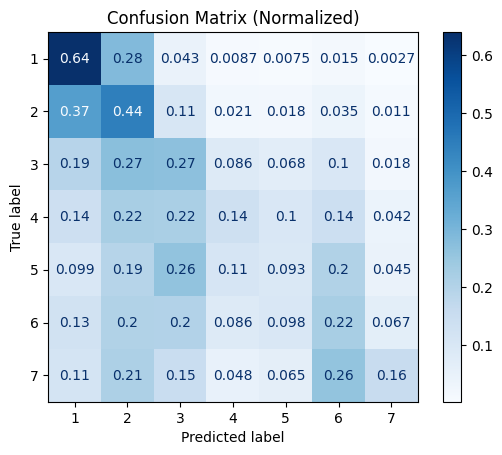

Validation accuracy: 0.4857
              precision    recall  f1-score   support

     Class 1       0.66      0.64      0.65      5197
     Class 2       0.45      0.44      0.44      3678
     Class 3       0.25      0.27      0.26      1095
     Class 4       0.16      0.14      0.15       402
     Class 5       0.11      0.09      0.10       335
     Class 6       0.10      0.22      0.14       255
     Class 7       0.19      0.16      0.17       186

    accuracy                           0.49     11148
   macro avg       0.27      0.28      0.27     11148
weighted avg       0.50      0.49      0.49     11148



In [40]:
# Predict on validation
y_pred = model.predict(X_val)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, len(class_counts)+1))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Normalized)")
plt.show()

# Accuracy and classification report
acc = (y_pred == y_val).mean()
print(f"Validation accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred, target_names=[f"Class {i}" for i in range(1, len(class_counts)+1)]))



### ordinal lgbm

In [41]:
model = LGBMOrdinal(class_weight='balanced')
# model = LGBMOrdinal()
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LGBMOrdinal(class_weight='balanced',
            objective=<function LGBMOrdinal._lgb_loss_factory.<locals>.loss at 0x7cc00aed9bc0>)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


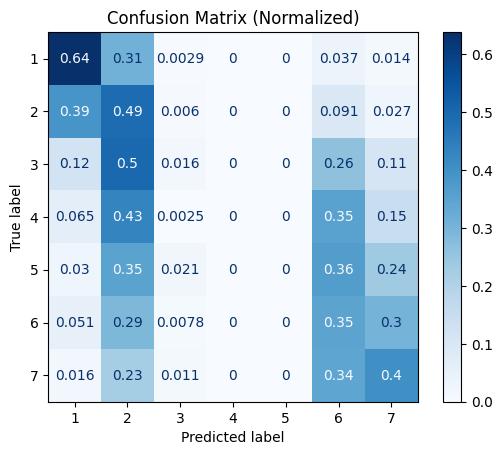

Validation accuracy: 0.4753
              precision    recall  f1-score   support

     Class 1       0.67      0.64      0.66      5197
     Class 2       0.41      0.49      0.45      3678
     Class 3       0.27      0.02      0.03      1095
     Class 4       0.00      0.00      0.00       402
     Class 5       0.00      0.00      0.00       335
     Class 6       0.07      0.35      0.12       255
     Class 7       0.13      0.40      0.20       186

    accuracy                           0.48     11148
   macro avg       0.22      0.27      0.21     11148
weighted avg       0.48      0.48      0.46     11148



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
# Predict on validation
y_pred = model.predict(X_val)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1, len(class_counts)+1))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Normalized)")
plt.show()

# Accuracy and classification report
acc = (y_pred == y_val).mean()
print(f"Validation accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred, target_names=[f"Class {i}" for i in range(1, len(class_counts)+1)]))

